# Step 13 - Testing Combined Kriging

In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import gempy as gp

# Importing auxiliary libraries
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd

from scipy import sparse
from scipy.sparse.linalg import splu

from skimage import measure
from scipy.spatial.distance import cdist

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib as mpl

# define the colormap
cmap = plt.cm.PuBu_r
# extract all colors
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,40,8)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [48]:
def get_distance_matrices(dist_matrix, target_point, n, prop_data):
    """
    Method to get closest points out of distance matrix calculated beforehand.
    Args:
        dist_matrix (np.array): matrix of distances between existing property data points (!), check SGS
        n(int): number of closest points used 
        target_point(int): index of target point
    Returns
        dist_close_all_to_all: 
        dist_close_target_to_all:
    """
    # check for n closest points in matrix (minimum distance values) and sort the resulting index array
    ind = np.argpartition(dist_matrix[target_point], n+1)[:n+1]
    sort_ind = np.sort(ind)
    
    #print(prop_data)
    # find new index of target point and create array to get target property values
    # THIS IS WHERE THE ERROR IS
    #print(sort_ind)
    ind_target = np.where(sort_ind == target_point)[0][0]
    #print(ind_target)
    ind_aux_prop = np.append(sort_ind[:ind_target],sort_ind[ind_target+1:]-1)
    #print(ind_aux_prop)
    
    # actually getting target property values in correct order
    closest_prop_data = prop_data[1][ind_aux_prop]
    #print(closest_prop_data)

    # extract distances from target point (row of target index)
    dist_close_target_to_all = dist_matrix[target_point][sort_ind]
    
    # find new index of target point (and save it for second part) and delete value to get correct distance matrix
    aux = np.where(dist_close_target_to_all == 0)[0][0]
    
    dist_close_target_to_all = dist_close_target_to_all[dist_close_target_to_all != 0] 
    
    # extract distance each to each for those closest points, delete target point index row and column
    dist_close_all_to_all = dist_matrix[np.ix_(sort_ind,sort_ind)]
    dist_close_all_to_all = np.delete(dist_close_all_to_all, aux, axis=0)
    dist_close_all_to_all = np.delete(dist_close_all_to_all, aux, axis=1)
        
    return dist_close_target_to_all, dist_close_all_to_all, closest_prop_data

In [49]:
def extract_submatrix(dist_matrix, property_data, target_point):
    # Method to extract submatrix from distance grid with all index points that contain property data

    # add target point to array with property data indices
    aux = np.append(property_data[0], target_point)
    aux = np.sort(aux)
    aux = aux.astype(int)
    
    # save where target point is in new submatrix
    target_point_in_sub = np.where(aux == target_point)[0][0]
    
    # extract submatrix by array
    submatrix = dist_matrix[np.ix_(aux,aux)]
    
    return submatrix, target_point_in_sub

In [61]:
def ordinary_kriging(target_point, a, b, prop):
    #def ordinary_kriging(point, data):
    
    # empty matrix building
    shape = len(a)
    C = np.zeros((shape+1, shape+1))
    c = np.zeros((shape+1))
    w = np.zeros((shape+1))
    
    # Faster matrix building approach, no loops
    C[:shape, :shape] = gaussian_variogram_model(b)
    c[:shape] = gaussian_variogram_model(a)
    
    # matrix setup - compare pykrige, special for OK
    np.fill_diagonal(C, 0)
    C[shape, :] = 1.0
    C[:, shape] = 1.0
    C[shape, shape] = 0.0  
    c[shape] = 1.0

    # Solve Kriging equations
    w = np.linalg.solve(C,c)
    #print(w[:shape])
    # SGS version - not correct yet, need to get mean and std
    result = np.random.normal(np.sum(w[:shape] * prop), scale=np.sqrt(w[shape]-gaussian_variogram_model(0)+np.sum(w[:shape]*c[:shape])))
    
    # direct version, calculating result from weights.
    # result = np.sum(w[:shape] * prop)
    
    return result

def sgs(dist_matrix, prop_data):
    
    # get prop data, lave original data untouched
    # prop_data = self.orig_prop_data
    
    
    # create array to go through SGS, only containing indices of grid points without data
    sgs_check = np.arange(0,len(dist_matrix[0]))
    sgs_check = np.delete(sgs_check, prop_data[0])
    
    for i in range(0, len(sgs_check)):
        
        # choose random target point from SGS check grid and delete it from list
        rand_int = np.random.randint(0,len(sgs_check))
        target_point = sgs_check[rand_int]
        sgs_check = np.delete(sgs_check, rand_int)
        #print(target_point)
        
        # extract submatrix required for distances
        submatrix, target_point_in_sub = extract_submatrix(dist_matrix, prop_data, target_point)
        
        # get closest distances
        a, b, prop = get_distance_matrices(submatrix, target_point_in_sub, 4, prop_data)
        #print(a)
        #print(b)
        #print(prop)
        
        # perform the Kriging interpolation on this point
        kriging_result = ordinary_kriging(target_point, a , b, prop) 
        
        #print(kriging_result)
        
        # add point to property data list
        prop_data = np.hstack((prop_data, ([[target_point], [kriging_result]])))
        prop_data = np.round(prop_data) # just for now
        prop_data = sorted(np.swapaxes(prop_data,0,1), key=lambda row: row[0])
        prop_data = np.vstack(prop_data)
        prop_data = np.swapaxes(prop_data,0,1)
    
    prop_data = np.round(prop_data) # just for now
    prop_data = sorted(np.swapaxes(prop_data,0,1), key=lambda row: row[0])
    prop_data = np.vstack(prop_data)
    prop_data = np.swapaxes(prop_data,0,1)
        
    return prop_data

In [62]:
def gaussian_variogram_model(d):
    range_ = 170
    sill = 40
    nugget = 10
    psill =sill-nugget
    gamma = psill * (1. - np.exp(-d**2./(range_)**2.))+nugget
    return gamma

## Simple Test

In [63]:
# simple test
a =np.arange(0,10,1)
b =np.arange(0,10,1)
xx,yy=np.meshgrid(a,b)
coord = np.vstack((xx.ravel(),yy.ravel()))
coord1 = np.swapaxes(coord,0,1)

vals = np.array([1,1,1,1,39,39,39,39])
inds = np.array([0,1,2,3,86,87,88,89])
prop_d = np.array((inds,vals))
dist_m = cdist(coord1, coord1)

In [64]:
result = sgs(dist_m, prop_d)

In [65]:
print(result)

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
  36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
  54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
  72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
  90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]
 [ 1.  1.  1.  1.  3.  3.  7.  1. 10.  8.  1. -0.  1.  3.  2.  4.  6.  6.
  14. 12. -0.  1.  2.  3.  8.  3. 13. 15. 17. 18.  3. -1.  0.  5.  5. 14.
  18. 19. 16. 19.  3.  7.  6.  8. 13. 17. 20. 21. 21. 23.  8.  9. 13. 14.
  20. 20. 19. 20. 26. 28.  9.  8. 12. 17. 25. 32. 26. 30. 29. 31. 12. 13.
  13. 21. 25. 31. 37. 35. 37. 36. 15. 19. 19. 26. 31. 31. 39. 39. 39. 39.
  15. 16. 20. 31. 27. 33. 35. 38. 41. 37.]]


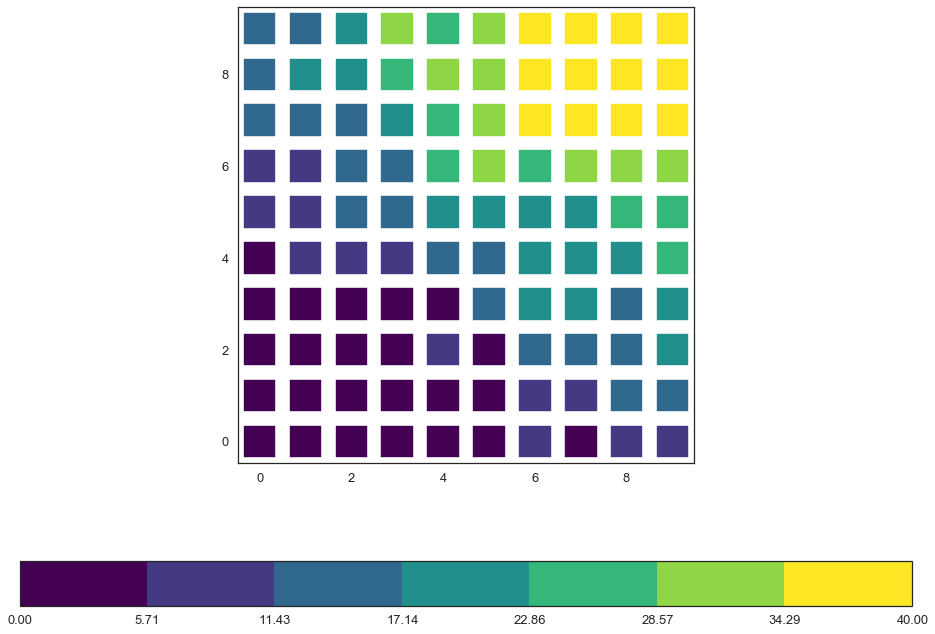

In [66]:
fig = plt.figure(figsize=(16,12))

a = plt.scatter(coord[0], coord[1], c=result[1], s=1000, marker=',', cmap='viridis', norm=norm)
#b = plt.scatter(data_f.X, data_f.Z, c=data_f.Property, s=35, marker='o', cmap=cmap, norm=norm, linewidths=1, edgecolors='black')

plt.axis('scaled')
fig.colorbar(a, orientation='horizontal')

## My testing model

In [67]:
# more complex testrun with the data I used before
domain = pd.read_csv("domain3d.csv")
data = pd.read_csv("data3d.csv")
variogram_fit = pd.read_csv("variogram_fit.csv")
range_ = variogram_fit.iloc[0][0]
sill = variogram_fit.iloc[0][1]
nugget = 10 # have to figure out a real way to do this

print(range_)
print(sill)

169.36528444850867
38.158275982164405


In [68]:
coord3d = domain.as_matrix(('X','Y','Z'))
dist_m = cdist(coord3d, coord3d)
coord3d_aux = np.swapaxes(coord3d, 0,1) # for plotting later
prop_coord = data.as_matrix(('X','Y','Z'))

C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [69]:
coord3d_round = np.round(coord3d, 2)
prop_coord_round = np.round(prop_coord, 2)

# finding positions of prop_data in grid
prop_d = np.zeros(len(prop_coord))

for i in range (len(prop_coord)):
    prop_d[i] = np.argwhere(np.all(coord3d_round == prop_coord_round[i], axis=1))[0][0]
    
values = data.as_matrix(('Property',))
prop_d = prop_d.reshape((200,1))

data_pos = np.hstack((prop_d, values))
data_pos = data_pos.transpose()
data_pos = data_pos.astype(int)


C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [70]:
result2 = sgs(dist_m, data_pos)

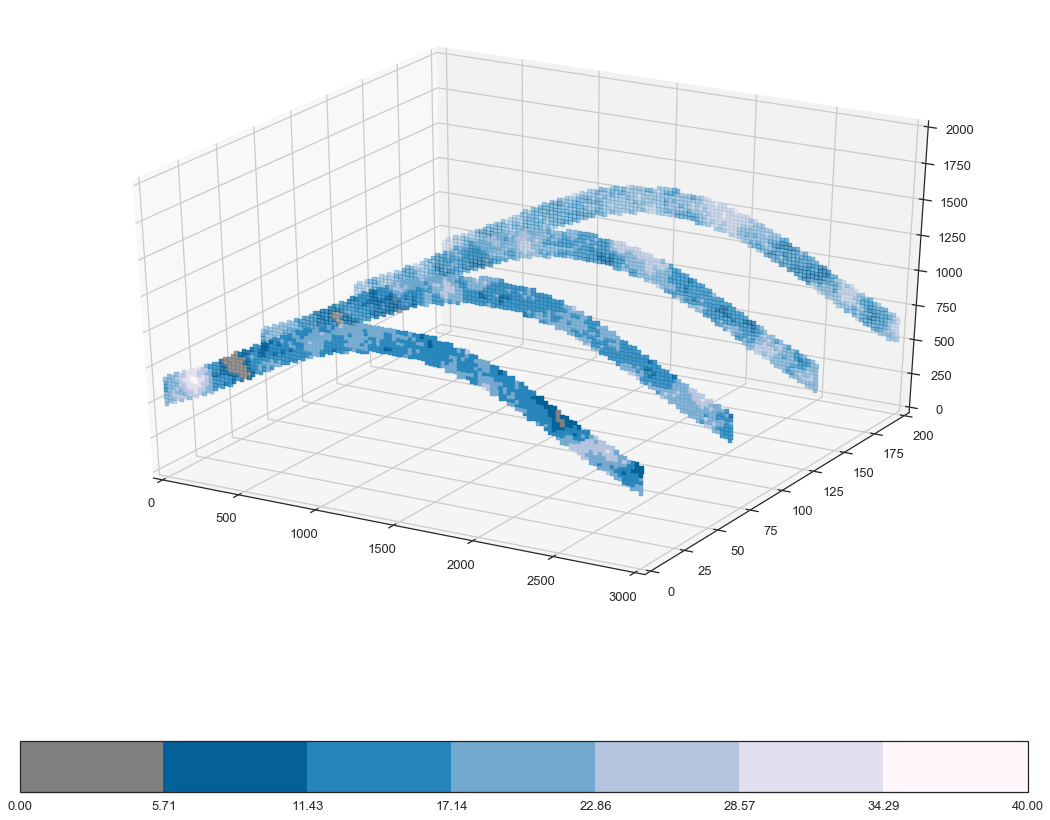

In [71]:
fig = plt.figure(figsize=(14, 12))
ax = Axes3D(fig)

ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
a = ax.scatter3D(xs=coord3d_aux[0],ys=coord3d_aux[1],zs=coord3d_aux[2], c=result2[1], s=20, marker=',', cmap=cmap, norm=norm)
# b = ax.scatter3D(xs=data.X,ys=data.Y,zs=data.Z, c=data.Property, s=50, marker='o', cmap=cmap, norm=norm, linewidths=1, edgecolors='black')

fig.colorbar(a, orientation='horizontal')